In [1]:
import os
os.chdir('../')

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "lagrangesolver",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "1",
    "--timesteps", "120",
    "--skip_type", "logSNR",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device

INFO - main.py - 2025-03-29 05:02:54,045 - Using device: cuda


[prepare_model] Loading ckpt from /data/checkpoints/dpm-solver/imagenet64_uncond_100M_1500K.pt ...
[prepare_model] Checkpoint loaded.
[prepare_model] Model is ready.


In [3]:
from tqdm import tqdm

def sample_in_batches(diffusion, config, device, total_samples=1024, batch_size=16):
    datas = []
    hists = []
    for i in tqdm(range(0, total_samples, batch_size)):
        bs = min(batch_size, total_samples - i)
        noise = np.random.randn(bs, config.data.channels, config.data.image_size, config.data.image_size).astype(np.float32)
        noise = torch.tensor(noise, device=device)
        (data, hist, x_pred, x_corr), _ = diffusion.sample_image(noise, diffusion.model, return_hist=True)
        datas.append(data)
        hists.append(torch.stack(hist, dim=0))
    return torch.cat(datas, dim=0), torch.cat(hists, dim=1)

datas, hists = sample_in_batches(diffusion, config, device, total_samples=256, batch_size=16)
print(datas.shape, hists.shape)

100%|██████████| 16/16 [01:00<00:00,  3.76s/it]

torch.Size([256, 3, 64, 64]) torch.Size([120, 256, 3, 64, 64])


In [8]:
!mkdir -p optimization/pair
save_file = 'optimization/pair/euler_NFE=120_N=256_data_evaluations.pt'
torch.save({'target': datas.data.cpu(),
            'hist': hists.data.cpu()
            }, save_file)
hists_load = torch.load(save_file)
hists_load['target'].shape
hists_load['hist'].shape

torch.Size([120, 256, 3, 64, 64])

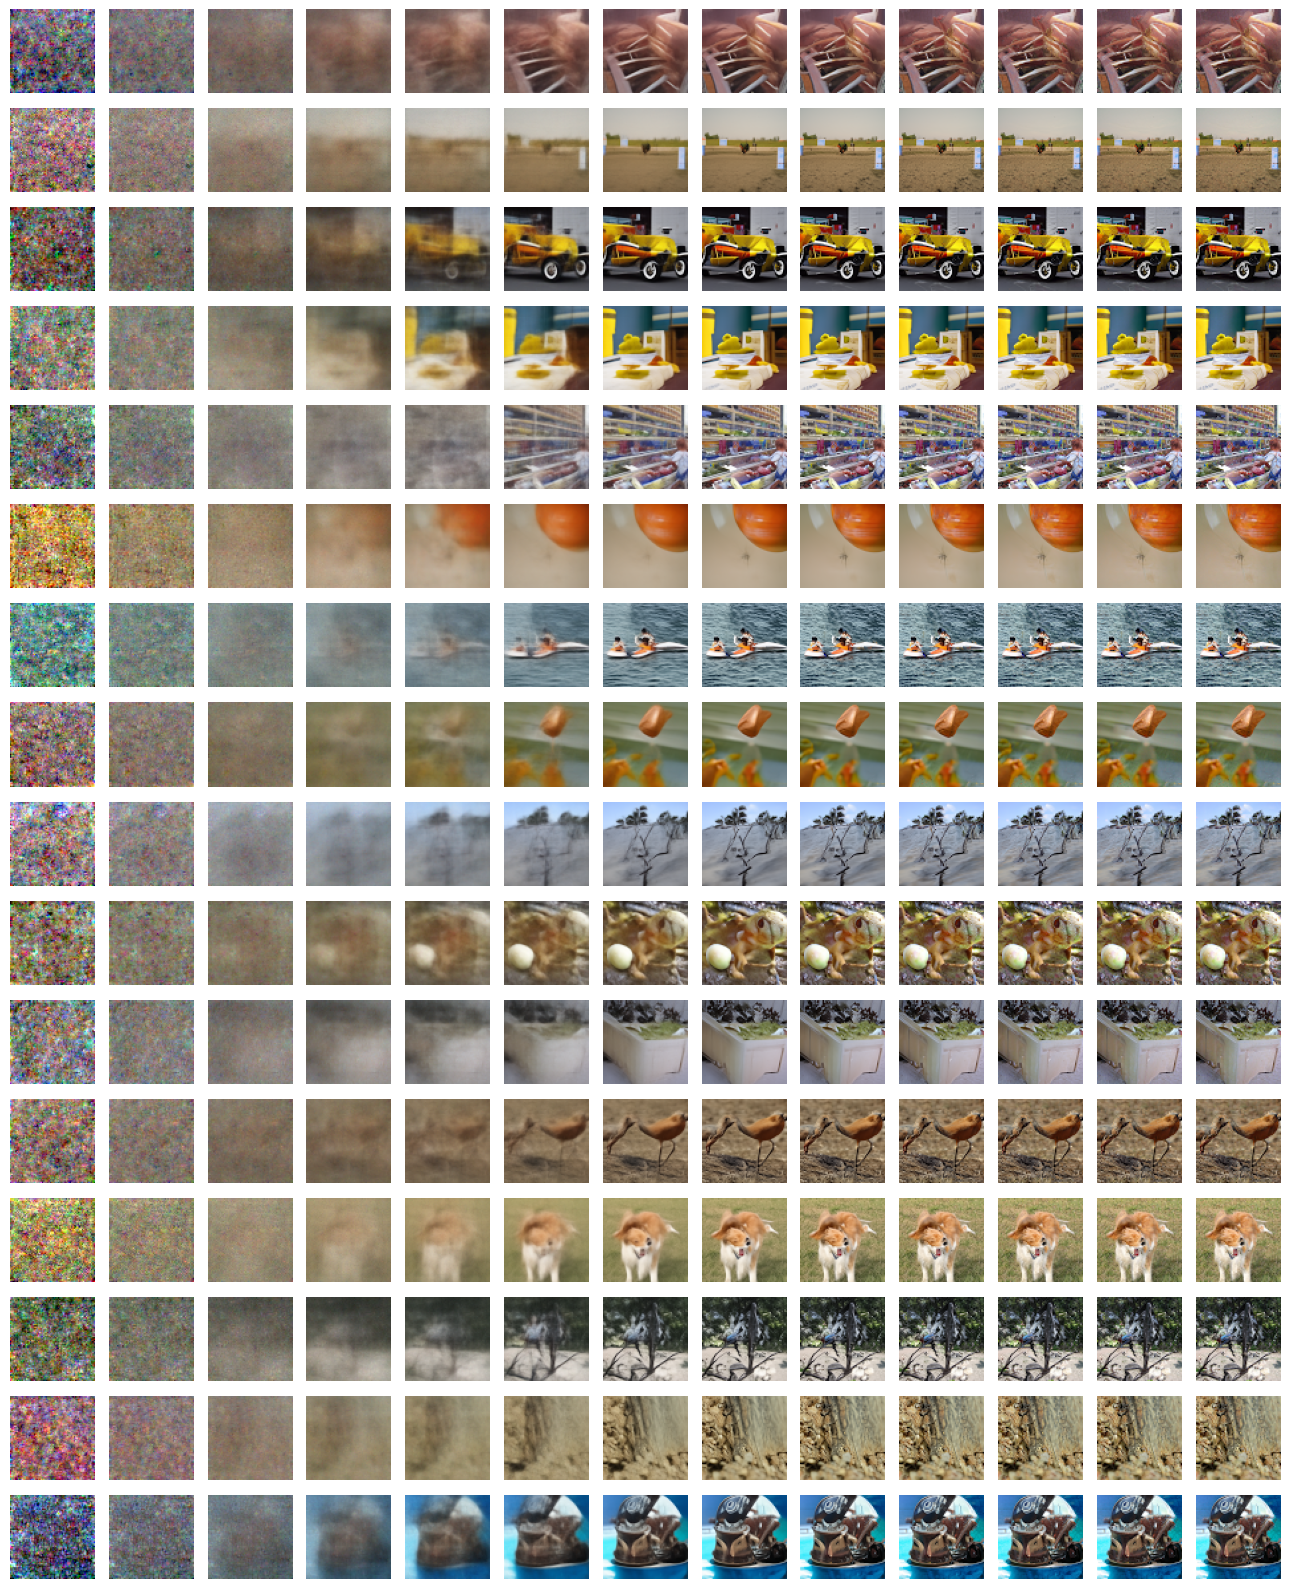

In [9]:
import torch
import matplotlib.pyplot as plt

# hists_load.shape == [256, 120, 3, 64, 64]

# 인스턴스 16개, 스텝 12개(10 간격)
nrows, ncols = 16, 12+1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))

for i in range(nrows):       # 인스턴스 인덱스 (0 ~ 15)
    for j in range(ncols):   # 스텝 간격 인덱스 (0 ~ 11)
        step = j * 10        # 실제 스텝: 0, 10, 20, ..., 110
        
        if j < ncols-1:
            img_tensor = hists_load['hist'][step, i]
        else:
            img_tensor = hists_load['target'][i]
        
        # inverse_data_transform (원하는 config와 함께 사용)
        # 예) img_tensor = inverse_data_transform(config, img_tensor)
        img_tensor = inverse_data_transform(config, img_tensor)
        
        # PyTorch 차원(채널, 높이, 너비)을 (높이, 너비, 채널)로 바꾸기
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        

plt.tight_layout()
plt.show()
